In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import data_tools as dt

In [17]:
from sklearn.datasets import make_blobs

X,y=make_blobs(n_samples=400,n_features=3,centers=3,random_state=42)

In [3]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2)

In [73]:
X_train.size()

torch.Size([320, 3])

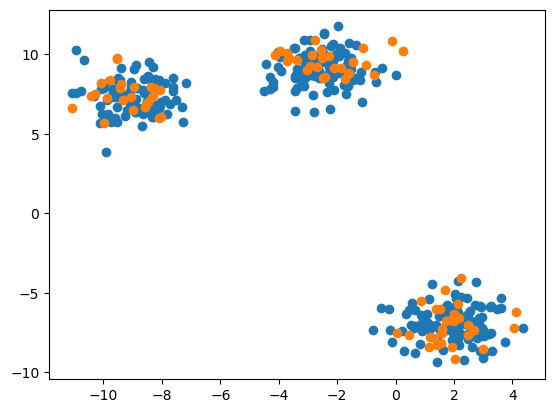

In [4]:
plt.scatter(X_train[:,0],X_train[:,1])
plt.scatter(X_test[:,0],X_test[:,1])

In [5]:
X_train=torch.from_numpy(X_train).type(torch.float)
X_test=torch.from_numpy(X_test).type(torch.float)
y_train=torch.from_numpy(y_train).type(torch.float)
y_test=torch.from_numpy(y_test).type(torch.float)

In [10]:
class DeepCluster(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_classes,num_clusters,):
        super().__init__()
        self.layers=nn.Sequential(nn.Linear(in_features=input_size,out_features=hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(in_features=hidden_size,out_features=output_size),
                                 nn.ReLU())
        
        self.cluster_layer=nn.Linear(output_size,num_clusters)
        
        self.class_layer=nn.Linear(output_size,num_classes)
    
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        output=self.layers(x)
        class_out=self.class_layer(output)
        cluster_out=self.cluster_layer(output)
        return class_out,cluster_out

In [81]:
def KMeansLoss(embeddings,n_clusters):
    
    batch_size,n_centers=embeddings.size()
    n_centers=torch.Tensor(n_centers)
    embedding_dim=embeddings.ndim

    embedding_reshape=embeddings.reshape(-1,embedding_dim)
    expand=n_centers.unsqueeze(1).expand(batch_size,-1)
    centers_reshaped=expand.reshape(-1,embedding_dim)

    distances=torch.nn.functional.pairwise_distance(embedding_reshape,centers_reshaped)

    distances=distances.reshape(batch_size,n_clusters)

    loss=torch.mean(torch.sum(distances,dim=1))

    return loss
    

In [82]:
model=DeepCluster(input_size=3,hidden_size=10,output_size=5,num_classes=4,num_clusters=3)

lr=1e-2
label_crit=nn.CrossEntropyLoss()
optim=torch.optim.Adam(model.parameters(),lr=lr)

In [47]:
label,cluster=model(X_train)


In [49]:
cluster.ndim

2

In [83]:
epochs=100
train_count=np.empty(0,dtype=np.float16)
test_count=np.array(0,dtype=np.float16)
epoch_count=np.array(0,dtype=np.int16)

for epoch in range(epochs):
    model.train()
    label,cluster=model(X_train)
    # label_loss=label_crit(y_train,label)
    cluster_loss=KMeansLoss(cluster,3)
    optim.zero_grad()
    total_loss=cluster_loss
    total_loss.backward()
    optim.step()
    
    train_count=np.append(train_count,total_loss)
    
    # with torch.inference_mode():
    #     test_preds=model(X_test)
    #     test_loss=criterion(y_test.detach(),test_preds)
    #     test_count=np.append(test_count,test_loss)
        
    epoch_count=np.append(epoch_count,epoch)
        
    if epoch%5==0:
        print(f"Epoch: {epoch: 3d} || train_loss: {total_loss: .10f}\n")

RuntimeError: The expanded size of the tensor (320) must match the existing size (3) at non-singleton dimension 0.  Target sizes: [320, -1].  Tensor sizes: [3, 1]